---
# Part II 🦀 Intermediate: Deep RL with Policy Gradient methods.
---

In [ ]:
# Install dependencies
%%capture

!pip install dm-haiku
!pip install optax
!pip install dm_env
!pip install gym[accept-rom-license]
!pip install dm-acme[envs]
!pip install autorom[accept-rom-license]

In [ ]:
# Imports

import collections
import random
from typing import Sequence

import chex
import dm_env
from dm_env import specs
import haiku as hk
import jax
import jax.numpy as jnp
from matplotlib import animation
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import optax
import gym
from acme.wrappers import atari_wrapper, gym_wrapper
from acme import wrappers
from matplotlib.patches import namedtuple

rc('animation', html='jshtml')
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [ ]:
#@title Some helper functions copied from 4.1

# Function to animate the observations
def animate(data, interval=200):
  fig = plt.figure(1)
  img = plt.imshow(data[0])
  plt.axis('off')

  def animate(i):
    img.set_data(data[i])

  anim = animation.FuncAnimation(fig, animate, frames=len(data), interval=interval)
  plt.close(1)
  return anim

_ACTIONS = (-1, 0, 1)  # Move paddle left, no-op, move paddle right.

class Catch(dm_env.Environment):
  """A Catch environment built on the dm_env.Environment class.

  The agent must move a paddle to intercept falling balls. Falling balls only
  move downwards on the column they are in.

  The observation is an array with shape (rows, columns) containing binary
  values: 0 if a space is empty; 1 if it contains the paddle and 2 for a ball.

  The actions are discrete, and by default there are three available actions:
  move left, stay, and move right.

  The episode terminates when the ball reaches the bottom of the screen.
  """

  def __init__(self,
               rows: int = 10,
               columns: int = 5,
               discount: float = 1.0):
    """Initializes a new Catch environment.

    Args:
      rows: number of rows.
      columns: number of columns.
      discount: discount factor for calculating reward.
    """
    self._rows = rows
    self._columns = columns
    self._discount = discount
    self._board = np.zeros((rows, columns), dtype=np.float32)
    self._ball_x = None
    self._ball_y = None
    self._paddle_x = None
    self._reset_next_step = True

  def reset(self) -> dm_env.TimeStep:
    """Returns the first `TimeStep` of a new episode."""
    self._reset_next_step = False
    # Ball can drop from any column.
    self._ball_x = np.random.randint(self._columns)
    self._ball_y = 0  # Top of matrix.
    self._paddle_x = self._columns // 2  # Centre.

    return dm_env.restart(self._observation())

  def step(self, action: int) -> dm_env.TimeStep:
    """Updates the environment according to the action."""
    if self._reset_next_step:
      return self.reset()

    # Move the paddle.
    dx = _ACTIONS[action]  # Get action. dx = change in x position.
    # Clip to keep paddle in bounds of the environment matrix.
    self._paddle_x = np.clip(self._paddle_x + dx, 0, self._columns - 1)

    # -----------------------------------#
    # Drop the ball down one row: increase y coordinate of the ball by 1.
    self._ball_y += 1
    # -----------------------------------#

    # Check for termination.
    if self._ball_y == self._rows - 1:  # Ball has fallen below the rows.
      # Reward depends on whether the paddle is on the ball (positions match).
      reward = 1. if self._paddle_x == self._ball_x else -1.
      self._reset_next_step = True
      return dm_env.termination(reward=reward, observation=self._observation())

    return dm_env.transition(reward=0., observation=self._observation(),
                             discount=self._discount)

  def observation_spec(self) -> specs.BoundedArray:
    """Returns the observation spec."""
    return specs.BoundedArray(
        shape=self._board.shape,
        dtype=self._board.dtype,
        name='board',
        minimum=0,
        maximum=2)

  def action_spec(self) -> specs.DiscreteArray:
    """Returns the action spec."""
    return specs.DiscreteArray(
        dtype=int, num_values=len(_ACTIONS), name='action')

  def _observation(self) -> np.ndarray:
    self._board.fill(0.)
    self._board[self._ball_y, self._ball_x] = 2.
    self._board[self._rows - 1, self._paddle_x] = 1.

    return self._board.copy()

# Function to animate the observations
def animate(data, interval=200):
  fig = plt.figure(1)
  img = plt.imshow(data[0])
  plt.axis('off')

  def animate(i):
    img.set_data(data[i])

  anim = animation.FuncAnimation(fig, animate, frames=len(data), interval=interval)
  plt.close(1)
  return anim

# Introduction to policy gradient RL
In this section, we are going to look at alternative to **value-based methods** approach: **policy gradient methods**.
The name "policy gradient" comes from the fact that we are estimating the gradient of the policy (rather than Q-function). **Policy-based methods** use iterative update rules to calculate the expected return associated with a state and action.

In order to learn, we need a loss function or *objective*. In RL, the general objective is to maximise the expected episode return by taking actions in the environment. Suppose that the agent's policy is parametrised by a function with paramethers $\theta$: then the actions are determined by $\pi_\theta(a|s)$. A very general way to represent a policy is with a neural network with parameters $\theta$. So, the task of RL is to find the neural network parameters $\theta$ that maximise

$$J(\pi_\theta)=\mathrm{E}_{\tau\sim\pi_\theta}\ [R(\tau)],$$

where $\mathrm{E}$ means *expectation*, $\tau$ is again shorthand for episode, and $R(\tau)$ denotes the return of episode $\tau$.

Then, the goal in RL is to find the parameters $\theta$ that maximise the function $J(\pi_\theta)$. One way to find the parameters $\theta$ that maximise $J(\pi_\theta)$ is to perform gradient ascent on $J(\pi_\theta)$ with respect to the parameters $\theta$.

$$\theta_{k+1}=\theta_k + \alpha \nabla J(\pi_\theta)|_{\theta_{k}},$$

where $\nabla J(\pi_\theta)|_{\theta_{k}}$ is the gradient of the expected return with respect to the policy parameters $\theta_k$ and $\alpha$ is the step size. This quantity, $\nabla J(\pi_\theta)$, is also called the **policy gradient**. If we can compute the policy gradient, then we will have a means by which to directly optimise our policy.

As it turns out, there is a [way](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) for us to compute the policy gradient:


$$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) R(\tau)].$$

Informaly, the policy gradient is equal to the gradient of the log of the probability of the action chosen, multiplied by the return of the episode in which the action was taken.
**REINFORCE** is a simple RL algorithm that uses the policy gradient to find the optimal policy by increasing the probability of choosing actions (*reinforcing* actions) that tend to lead to high return episodes.


In this part, we will start by experimenting with the CartPole environment. As a reminder, this is how we load it:

In [ ]:
env = gym_wrapper.GymWrapper(gym.make('CartPole-v1'))
env = wrappers.SinglePrecisionWrapper(env)

## Rewards-to-go
Performing gradient ascent on the gradient of the log of the action probability, weighted by the return of the episode will tend to push up the probability of actions that were in episodes with high return, regardless of *where* in the episode the action was taken. This does not really make much sense because an action near the end of an episode may be reinforced because lots of reward was collected earlier on in the episode, *before* the action was taken. RL agents should really only reinforce actions on the basis of their *consequences*. Rewards obtained before taking an action have no bearing on how good that action was: only rewards that come after. The cummulative rewards received after an action was taken is called the **rewards-to-go** and can be computed as:

$$\hat{R}_i=\sum_{t=i}^Tr_t.$$

Compare this to the episode return:

$$R(\tau)=\sum_{t=0}^Tr_t.$$

We can improve the reliability of the policy gradient by substituting the episode return with the rewards-to-go. The policy gradient with rewards-to-go is given by:

$$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) \hat{R}_t].$$

### ⭐ Exercise

Implement a function that takes a list of all the rewards obtained in an episode and computes the rewards-to-go.

In [ ]:
def compute_rewards_to_go(rewards):
  rewards_to_go = []
  # -----------------------------------#
  # Given a list of rewards, return a list of rewards to go
  for i in range(len(rewards)):
    r2g = 0
    for j in range(i, len(rewards)):
      r2g += rewards[j]
    rewards_to_go.append(r2g)
  # -----------------------------------#
  return rewards_to_go

In [ ]:
# Example
rewards_to_go = compute_rewards_to_go([1, 1, 1, 1, 0])
print('rewards_to_go:', rewards_to_go)
print('rewards_to_go should be [4, 3, 2, 1, 0]')

rewards_to_go: [4, 3, 2, 1, 0]
rewards_to_go should be [4, 3, 2, 1, 0]


## Handling the data
We will need to make a new agent memory to store the rewards-to-go $\hat{R}_t$ along with the observation $o_t$ and action $a_t$ at every timestep. As before, the memory class implements the basic functions `__init__, push, sample, is_ready`. The memory now has a maximum size and the sampling function return a batch of samples.

In [ ]:
# For the purpose of this section, we redefine transition to include if the observation is final
Transition = collections.namedtuple(
    'Transition', 'obs_tm1 a_tm1 r_t obs_t done')
EpisodeRewardsToGoMemory = collections.namedtuple(
    'EpisodeRewardsToGoMemory', 'obs, action, reward_to_go')


class EpisodeRewardsToGoBuffer:
  def __init__(self, num_transitions_to_store=512, batch_size=256):
    self.batch_size = batch_size
    self.memory_buffer = collections.deque(maxlen=num_transitions_to_store)
    self.current_episode_transition_buffer = []

  def push(self, transition):
    self.current_episode_transition_buffer.append(transition)
    if transition.done:
      episode_rewards = []
      for t in self.current_episode_transition_buffer:
        episode_rewards.append(t.r_t)
      r2g = compute_rewards_to_go(episode_rewards)
      for i, t in enumerate(self.current_episode_transition_buffer):
        memory = EpisodeRewardsToGoMemory(t.obs_tm1, t.a_tm1, r2g[i])
        self.memory_buffer.append(memory)
      # Reset episode buffer
      self.current_episode_transition_buffer = []

  def sample(self):
    random_memory_sample = random.sample(self.memory_buffer, self.batch_size)
    obs_batch, action_batch, reward_to_go_batch = zip(*random_memory_sample)
    return EpisodeRewardsToGoMemory(
        np.stack(obs_batch).astype("float32"),
        np.asarray(action_batch).astype("int32"),
        np.asarray(reward_to_go_batch).astype("int32")
    )

  def is_ready(self):
    return len(self.memory_buffer) >= self.batch_size

# Instantiate Memory
REINFORCE_memory = EpisodeRewardsToGoBuffer(num_transitions_to_store=512, batch_size=256)

# REINFORCE Agent

We will use the same structure for the agent class as before, it will include `__init__`, `actor_step` and `learner_step` functions. In addition, as the policy is now represented by a neural network, we will use helper functions `initial_params` and `initial_learner_state`.

## ⭐ Exercise

1) **Policy neural network.**
Our policy neural network policy will take the observation as input and passes it through an MLP with `len(num_hiddens)` hidden layers and then outputs one scalar value for each of the possible actions (`2` in CartPole). The outputs of our policy network are [logits](https://qr.ae/pv4YTe). We will use Jax and Haiku for the neural network training. Please have a look [here](https://dm-haiku.readthedocs.io/en/latest/api.html) to understand Haiku transformations. Use [Haiku](https://github.com/deepmind/dm-haiku) (a library for implementing neural networks is JAX) to fill in the gaps in the policy `network` function. Hint: use functions `hk.Flatten` and `hk.nets.MLP`. Having done this, you can run the next cell "Network test" to check your implementation. You may need to comment out incomplete functions when running the tests.

2) **Actor function.**
Next we implement `actor_step` function, which takes network parameters, timestep and random key and returns an action of the policy. Fill in the gaps in the `actor_step` function. Use [`jax.random.categorical`](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.categorical.html) function to sample an action given the logits. Having done this, you can run the cell after "Actor test" to check your implementation.

3) **Learner function.**
Finally, we implement the learner function that computes the gradient of the loss and makes a step. Remember, the loss function is

$$- \log \pi_{\theta}(a_{t} \mid s_{t}) \hat{R}_t.$$
We also added an [Adam optimizer](https://arxiv.org/abs/1412.6980), which is a very popular optimiser that requires little tuning. Fill in the gaps in the `_loss` function. First, convert `logits` into probabilities (use [softmax](https://en.wikipedia.org/wiki/Softmax_function) function), and then, weight them by the `rewards_to_go`. Having done this, you can run the cell after "Loss test" to check your implementation.

In [ ]:
class REINFORCEAgent(object):
  """Q-learning agent."""

  def __init__(self,
               action_spec: specs.DiscreteArray,
               observation_spec: specs.DiscreteArray,
               num_hiddens: Sequence[int] = [50],
               learning_rate: float = 0.005):
    self._observation_spec = observation_spec
    self._num_actions = action_spec.num_values
    self._optimizer = optax.adam(learning_rate)

    def network(obs):
      """Q network of the agent."""
      mlp = hk.Sequential(
          # -----------------------------------#
          [
              # Flatten the input with haiku
              hk.Flatten(),
              # MLP with layers of dimension num_hiddens followed by a layer with self._num_actions units
              hk.nets.MLP(num_hiddens + [self._num_actions])])
          # -----------------------------------#
      return mlp(obs)

    self._network = hk.without_apply_rng(hk.transform(network)) #, apply_rng=True))
    # Jitting for speed. Can comment out for debugging
    self.actor_step = jax.jit(self.actor_step)
    self.learner_step = jax.jit(self.learner_step)

  def initial_params(self, rng_key):
    """Initialises the agent params given the RNG key."""
    sample_input = self._observation_spec.generate_value()
    sample_input = jnp.expand_dims(sample_input, 0)
    # Haiku networks have network.init(<random_key>, <input>) function
    # which returns a set of random initial parameters.
    return self._network.init(rng_key, sample_input)

  def initial_learner_state(self, params):
    """Initialises the state of the optimizer."""
    return self._optimizer.init(params)

  def actor_step(self, params, timestep, rng_key):
    """."""
    obs = jnp.expand_dims(timestep.observation, 0)  # Add dummy batch.
    # Pass obs through policy network to compute logits
    logits = self._network.apply(params, obs)
    # Remove batch dim
    logits = logits[0]
    # -----------------------------------#
    # Randomly sample action
    action = jax.random.categorical(rng_key, logits)
    # -----------------------------------#
    return action

  def _loss(self, params, obs, action, reward_to_go):

    def policy_gradient_loss(action, logits, reward_to_go):
      # -----------------------------------#
      # Convert logits into probs
      all_action_probs = jax.nn.softmax(logits)
      # Get the probability of action corresponding to the input _action_
      action_prob = all_action_probs[action]
      # Compute_weighted_log_prob: log of the prob, multiplied by _reward_to_go_
      log_prob = jax.numpy.log(action_prob)
      weighted_log_prob = log_prob * reward_to_go
      # -----------------------------------#
      return -weighted_log_prob

    logits_batch = self._network.apply(params, obs)
    batched_loss = jax.vmap(policy_gradient_loss)
    loss = jnp.mean(batched_loss(action, logits_batch, reward_to_go))
    return loss, loss

  def learner_step(self, params: hk.Params, data, learner_state, rng_key):
    """Computes loss, its gradient w.r.t. params, and runs an optimisation step."""

    # Get the policy gradient by using `jax.grad()` on `batched_policy_gradient_loss`
    grad_loss, loss = jax.grad(self._loss, has_aux=True)(params, *data)
    updates, learner_state = self._optimizer.update(
        grad_loss, learner_state)
    params = optax.apply_updates(params, updates)
    return params, learner_state, loss

### Network test

In [ ]:
# Example of initialising the agent and making a dummy observation pass through the network
agent = REINFORCEAgent(env.action_spec(),
                       env.observation_spec())

rng = jax.random.PRNGKey(42)
params = agent.initial_params(rng)
learner_state = agent.initial_learner_state(params)

print('Policy network paremeter keys:', params.keys())

dummy_obs = np.ones(env.observation_spec().shape, "float32")
dummy_obs = jnp.expand_dims(dummy_obs, 0) # add batch obs

# `network.apply(<params>, <input>)` passes an input through the network using the set of provided parameters
logits = agent._network.apply(params, dummy_obs)
print("Policy network logits:", logits)
print("The policy network logits should be [[ 0.748849   -0.04347724]]")

Policy network paremeter keys: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1'])
Policy network logits: [[ 0.748849   -0.04347724]]
The policy network logits should be [[ 0.748849   -0.04347724]]


### Actor test

In [ ]:
# Example of using actor funtion
agent = REINFORCEAgent(env.action_spec(),
                       env.observation_spec())

DummyTransition = collections.namedtuple(
    'DummyTransition', 'observation')
dummy_timestep = DummyTransition(np.ones(env.observation_spec().shape, "float32"))
action = agent.actor_step(params, dummy_timestep, rng)
print('Action:', action)
print('Action should be 1')

Action: 1
Action should be 1


### Loss test

In [ ]:
# Example
agent = REINFORCEAgent(env.action_spec(),
                       env.observation_spec())

# Create a batch of dummy observations, actions and rewards_to_go
obs_batch = np.ones((5,*env.observation_spec().shape), "float32")
actions_batch = np.array([1, 0, 0, 1, 0])
rew2go_batch = np.array([2.3, 4.3, 2.1, 10, 100])

loss = agent._loss(params, obs_batch, actions_batch, rew2go_batch)
print('Loss = ', loss[0])
print('Loss should be 10.815681')

Loss =  10.815681
Loss should be 10.815681


## Learning loop

Finally, let's run the learning loop. As the structure of the agent is very similar to Q-learning agent, the learning loop is very similar as well. A few differences to note:

- We are handling data slightly differently as we need to compute rewards to go
- A learning step is performed after the whole epsidose is added to the `accumulator`
- A learning step is performed on a batch of samples instead of a single datapoint.

### ⭐ Exercise

- Choose the parameters (number of training episodes, numbers of hidden units in MLP, learning rate, batch size) so that the average return of the agent increases with training and ends up being greater than $200$.
- Run the learning loop and visualise the epsiode returns. Look at the animation of the last episode. Optional: modify the code to keep an episode every x iterations and look at the progression of the agents.
- Note that this time we do not have $\epsilon$-greedy agent for the exploration. Why is it not necessary?

In [ ]:
train_episodes = 301  # @param
evaluate_every = 10  # @param
eval_episodes = 10  # @param
num_hiddens = [20, 20]  # @param
learning_rate = 1e-3  # @param
batch_size = 256  # @param
num_transitions_to_store = 512  # @param
seed = 1221

rng = hk.PRNGSequence(jax.random.PRNGKey(seed))

# Initialise the environment.
env = gym_wrapper.GymWrapper(gym.make('CartPole-v1'))
env = wrappers.SinglePrecisionWrapper(env)

timestep = env.reset()

# Build and initialise the agent.
agent = REINFORCEAgent(env.action_spec(),
                       env.observation_spec(),
                       num_hiddens=num_hiddens,
                       learning_rate=learning_rate)

params = agent.initial_params(next(rng))
learner_state = agent.initial_learner_state(params)

# Initialise the accumulator.
accumulator = EpisodeRewardsToGoBuffer(num_transitions_to_store=num_transitions_to_store, batch_size=batch_size)

# Run loop.
avg_returns = []
losses = []

for episode in range(train_episodes):

  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  obs = timestep.observation

  frames = []
  while not timestep.last():
    frames.append(env.render(mode='rgb_array'))
    # Acting.
    action = agent.actor_step(params, timestep, next(rng))
    # Agent-environment interaction.
    timestep = env.step(int(action))
    # Accumulate experience.
    reward = timestep.reward
    next_obs = timestep.observation
    done = timestep.last()
    # Pack into transition.
    transition = Transition(obs, action, reward, next_obs, done)
    accumulator.push(transition)
    obs = next_obs

  # Note that here we are training only at the end of the episode
  # Learning.
  if accumulator.is_ready():
    batch = accumulator.sample()
    params, learner_state, loss = agent.learner_step(
        params, accumulator.sample(), learner_state, next(rng))
    losses.append(np.asarray(loss))
  # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(params, timestep, next(rng))
        timestep = env.step(int(action))
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f"Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}")

Episode    0: Average returns: 24.80
Episode   10: Average returns: 20.50
Episode   20: Average returns: 16.10
Episode   30: Average returns: 25.30
Episode   40: Average returns: 35.60
Episode   50: Average returns: 31.70
Episode   60: Average returns: 21.10
Episode   70: Average returns: 43.60
Episode   80: Average returns: 37.20
Episode   90: Average returns: 41.40
Episode  100: Average returns: 35.70
Episode  110: Average returns: 50.40
Episode  120: Average returns: 65.70
Episode  130: Average returns: 59.50
Episode  140: Average returns: 49.00
Episode  150: Average returns: 63.30
Episode  160: Average returns: 63.70
Episode  170: Average returns: 55.70
Episode  180: Average returns: 69.20
Episode  190: Average returns: 80.10
Episode  200: Average returns: 90.60
Episode  210: Average returns: 82.20
Episode  220: Average returns: 114.80
Episode  230: Average returns: 169.30
Episode  240: Average returns: 222.00
Episode  250: Average returns: 205.30
Episode  260: Average returns: 217

In [ ]:
# Animate the last epsiode
animate(frames, interval=50)

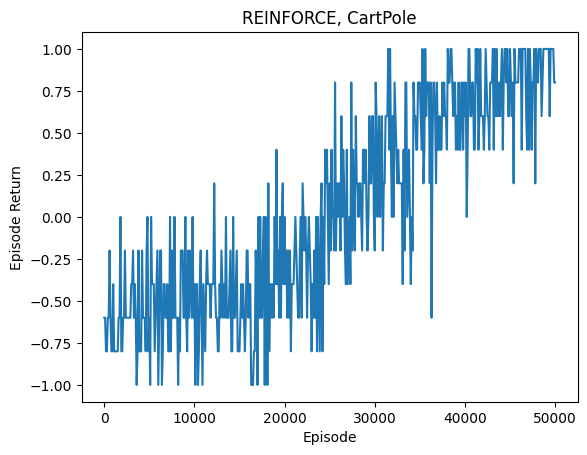

In [ ]:
# -----------------------------------#
# Plot the return
plt.plot(np.arange(len(avg_returns))*evaluate_every, avg_returns)
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("REINFORCE, CartPole")
plt.show()
# -----------------------------------#

### ⭐ Bonus exercise
Next, try to use Catch environment as a training environment. You can try computing the observation representation as we did in Part I of this tutorial, or you can try learning directly from the state ("from pixels"), which would similar to Atari and would require more training episodes.

In [ ]:
# -----------------------------------#
train_episodes = 50_001  # @param
evaluate_every = 100  # @param
eval_episodes = 10  # @param
num_hiddens = [20, 20]  # @param
learning_rate = 1e-5  # @param
batch_size = 256  # @param
num_transitions_to_store = 512  # @param
seed = 1221

rng = hk.PRNGSequence(jax.random.PRNGKey(seed))

# Initialise the environment.
env = Catch()

timestep = env.reset()

# Build and initialise the agent.
agent = REINFORCEAgent(env.action_spec(),
                       env.observation_spec(),
                       num_hiddens=num_hiddens,
                       learning_rate=learning_rate)

params = agent.initial_params(next(rng))
learner_state = agent.initial_learner_state(params)

# Initialise the accumulator.
accumulator = EpisodeRewardsToGoBuffer(num_transitions_to_store=num_transitions_to_store, batch_size=batch_size)

# Run loop.
avg_returns = []
losses = []

for episode in range(train_episodes):

  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  obs = timestep.observation

  while not timestep.last():
    # Acting.
    action = agent.actor_step(params, timestep, next(rng))
    # Agent-environment interaction.
    timestep = env.step(int(action))
    # Accumulate experience.
    reward = timestep.reward
    next_obs = timestep.observation
    done = timestep.last()
    # Pack into transition.
    transition = Transition(obs, action, reward, next_obs, done)
    accumulator.push(transition)
    obs = next_obs

  # Note that here we are training only at the end of the episode
  # Learning.
  if accumulator.is_ready():
    batch = accumulator.sample()
    params, learner_state, loss = agent.learner_step(
        params, accumulator.sample(), learner_state, next(rng))
    losses.append(np.asarray(loss))
  # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(params, timestep, next(rng))
        timestep = env.step(int(action))
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f"Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}")
# -----------------------------------#

Episode    0: Average returns: -0.60
Episode  100: Average returns: -0.60
Episode  200: Average returns: -0.80
Episode  300: Average returns: -0.80
Episode  400: Average returns: -0.60
Episode  500: Average returns: -0.60
Episode  600: Average returns: -0.20
Episode  700: Average returns: -0.60
Episode  800: Average returns: -0.80
Episode  900: Average returns: -0.80
Episode 1000: Average returns: -0.40
Episode 1100: Average returns: -0.80
Episode 1200: Average returns: -0.80
Episode 1300: Average returns: -0.80
Episode 1400: Average returns: -0.80
Episode 1500: Average returns: -0.80
Episode 1600: Average returns: -0.60
Episode 1700: Average returns: -0.60
Episode 1800: Average returns: 0.00
Episode 1900: Average returns: -0.80
Episode 2000: Average returns: -0.80
Episode 2100: Average returns: -0.60
Episode 2200: Average returns: -0.60
Episode 2300: Average returns: -0.20
Episode 2400: Average returns: -0.60
Episode 2500: Average returns: -0.60
Episode 2600: Average returns: -0.60
Ep

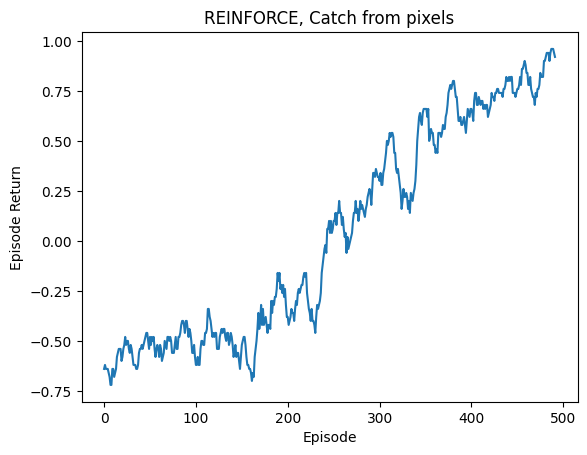

In [ ]:
# -----------------------------------#
plt.plot(np.convolve(avg_returns, np.ones(10)/10, 'valid'))
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("REINFORCE, Catch from pixels")
plt.show()
# -----------------------------------#